In [1]:
# We're going to start off in a jupyter notebook and slowly move this into a widget... for visualization with tests and stuff
#%matplotlib 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from functools import reduce
from operator import concat
import glob
import json
import pandas as pd

import seaborn as sns
# sns.set_theme()

In [2]:

def find_walks_with_type(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    if ID == 6 and walktype == 'pavement':
         walks = [2]
    walkNum = walks
    return walkNum


def load_data(ID,walkNum):

    footholds = []
    gazeGround = []
    skeletons = []
    hips = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')   
        marker,skeleton,fholds,gGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        footholds.append(fholds)
        gazeGround.append(gGround)
        skeletons.append(skeleton)
        hips.append(np.squeeze(skeleton[:,1,:]))
    return footholds, gazeGround, skeleton, hips


#### sub functions for calculating relative fixation info

def convert_footholds_to_gaze_time(fholds,gaze):
    frame_edges = np.append(np.append(1,fholds[:,0]),gaze.shape[0]+1)
    frames_per_foothold = np.diff(frame_edges)
    current = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))
    return current

def find_closest_foothold_to_gaze(fholds,gaze):
    d = cdist(gaze,fholds[:,2:])
    closest= np.argmin(d,axis=1)+1
    distance = np.min(d,axis=1)
    return closest,distance


def calculate_gaze_distance(gaze,hip_location):
    dist = np.linalg.norm(gaze[:,[0,2]]-hip_location[:,[0,2]],axis=1)
    return dist

#### END ################################################

def find_rel_foothold_fixation(fholds,gaze,hip_location):
    
    current_footholds = convert_footholds_to_gaze_time(fholds,gaze)
    closest_footholds, distance = find_closest_foothold_to_gaze(fholds,gaze)
    gaze_distance = calculate_gaze_distance(gaze,hip_location)
    relative_foothold = np.where(distance<.4, closest_footholds-current_footholds, np.nan)

    return relative_foothold,gaze_distance,current_footholds,closest_footholds

def perform_relative_foothold_analysis(subj,walk_type):
    walkNum = find_walks_with_type(subj,walk_type)
    footholds,gazeGround,skeletons,hips = load_data(subj,walkNum)
    
    with open(f'/N/project/berkeley_walking/BerkeleyData/legLength.json', "r") as f:
        ll = json.load(f)
        leg_length = float(ll[f's{subj}'])/100 # convert from cm to m

    
    # calculating relative foothold information for these walks
    gaze_distances = []
    gaze_distances_leg = []
    relative_footholds = []
    for fholds,gaze,hip_location in zip(footholds,gazeGround,hips):
        rfholds,gdist,_,_ = find_rel_foothold_fixation(fholds,gaze,hip_location)
        gaze_distances.append(gdist)
        relative_footholds.append(rfholds)
        gaze_distances_leg.append(gdist/leg_length)
        

    gaze_distances = np.concatenate(gaze_distances)
    relative_footholds = np.concatenate(relative_footholds)
    gaze_distances_leg = np.concatenate(gaze_distances_leg)
    return gaze_distances, relative_footholds, gaze_distances_leg

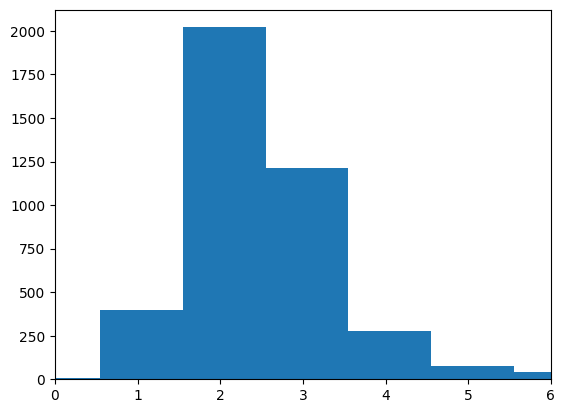

In [3]:
gaze_distances, relative_footholds, gaze_distances_leg = perform_relative_foothold_analysis(3,'rock')
    
# step histogram (where people look relative to their steps)
plt.hist(relative_footholds, bins= np.arange(np.nanmin(relative_footholds)-.95,
               np.nanmax(relative_footholds)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.show()


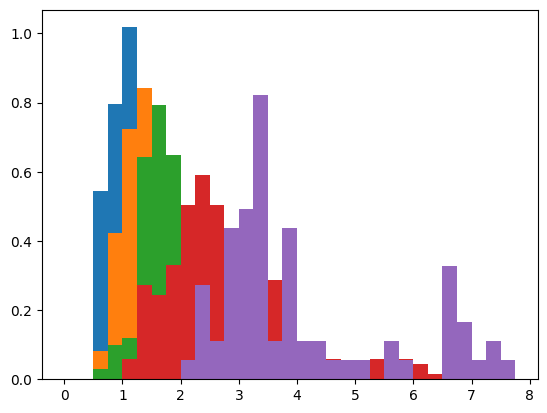

In [4]:
# distance histogram (how far is that from their body "along the ground")

for ii in range(1,6):
    plt.hist(gaze_distances[relative_footholds==ii],bins= np.arange(0,8,.25),density=True)
    


In [5]:
# pooling the relative foothold fixations in each subject for each walk type

terrain_types = ['rock','medium','flat','pavement']
steps = {}
distances = {}
distances_leg = {}

for terrain in terrain_types:
    steps[terrain] = []
    distances[terrain] = []
    distances_leg[terrain] = []
    for x in range(3,11):    
        gaze_distances, relative_footholds, gaze_distances_leg = perform_relative_foothold_analysis(x,terrain)
        steps[terrain].append(relative_footholds)
        distances[terrain].append(gaze_distances)
        distances_leg[terrain].append(gaze_distances_leg)


In [6]:
def plot_par(rows,cols,n,steps):
    plt.subplot(rows,cols,n)
    plt.hist(steps, bins= np.arange(np.nanmin(steps)-.95,
               np.nanmax(steps)+ .95,1), align = 'right', rwidth = 1.88)
    plt.xlim(0,6)
    plt.xticks(np.arange(1,6,1))

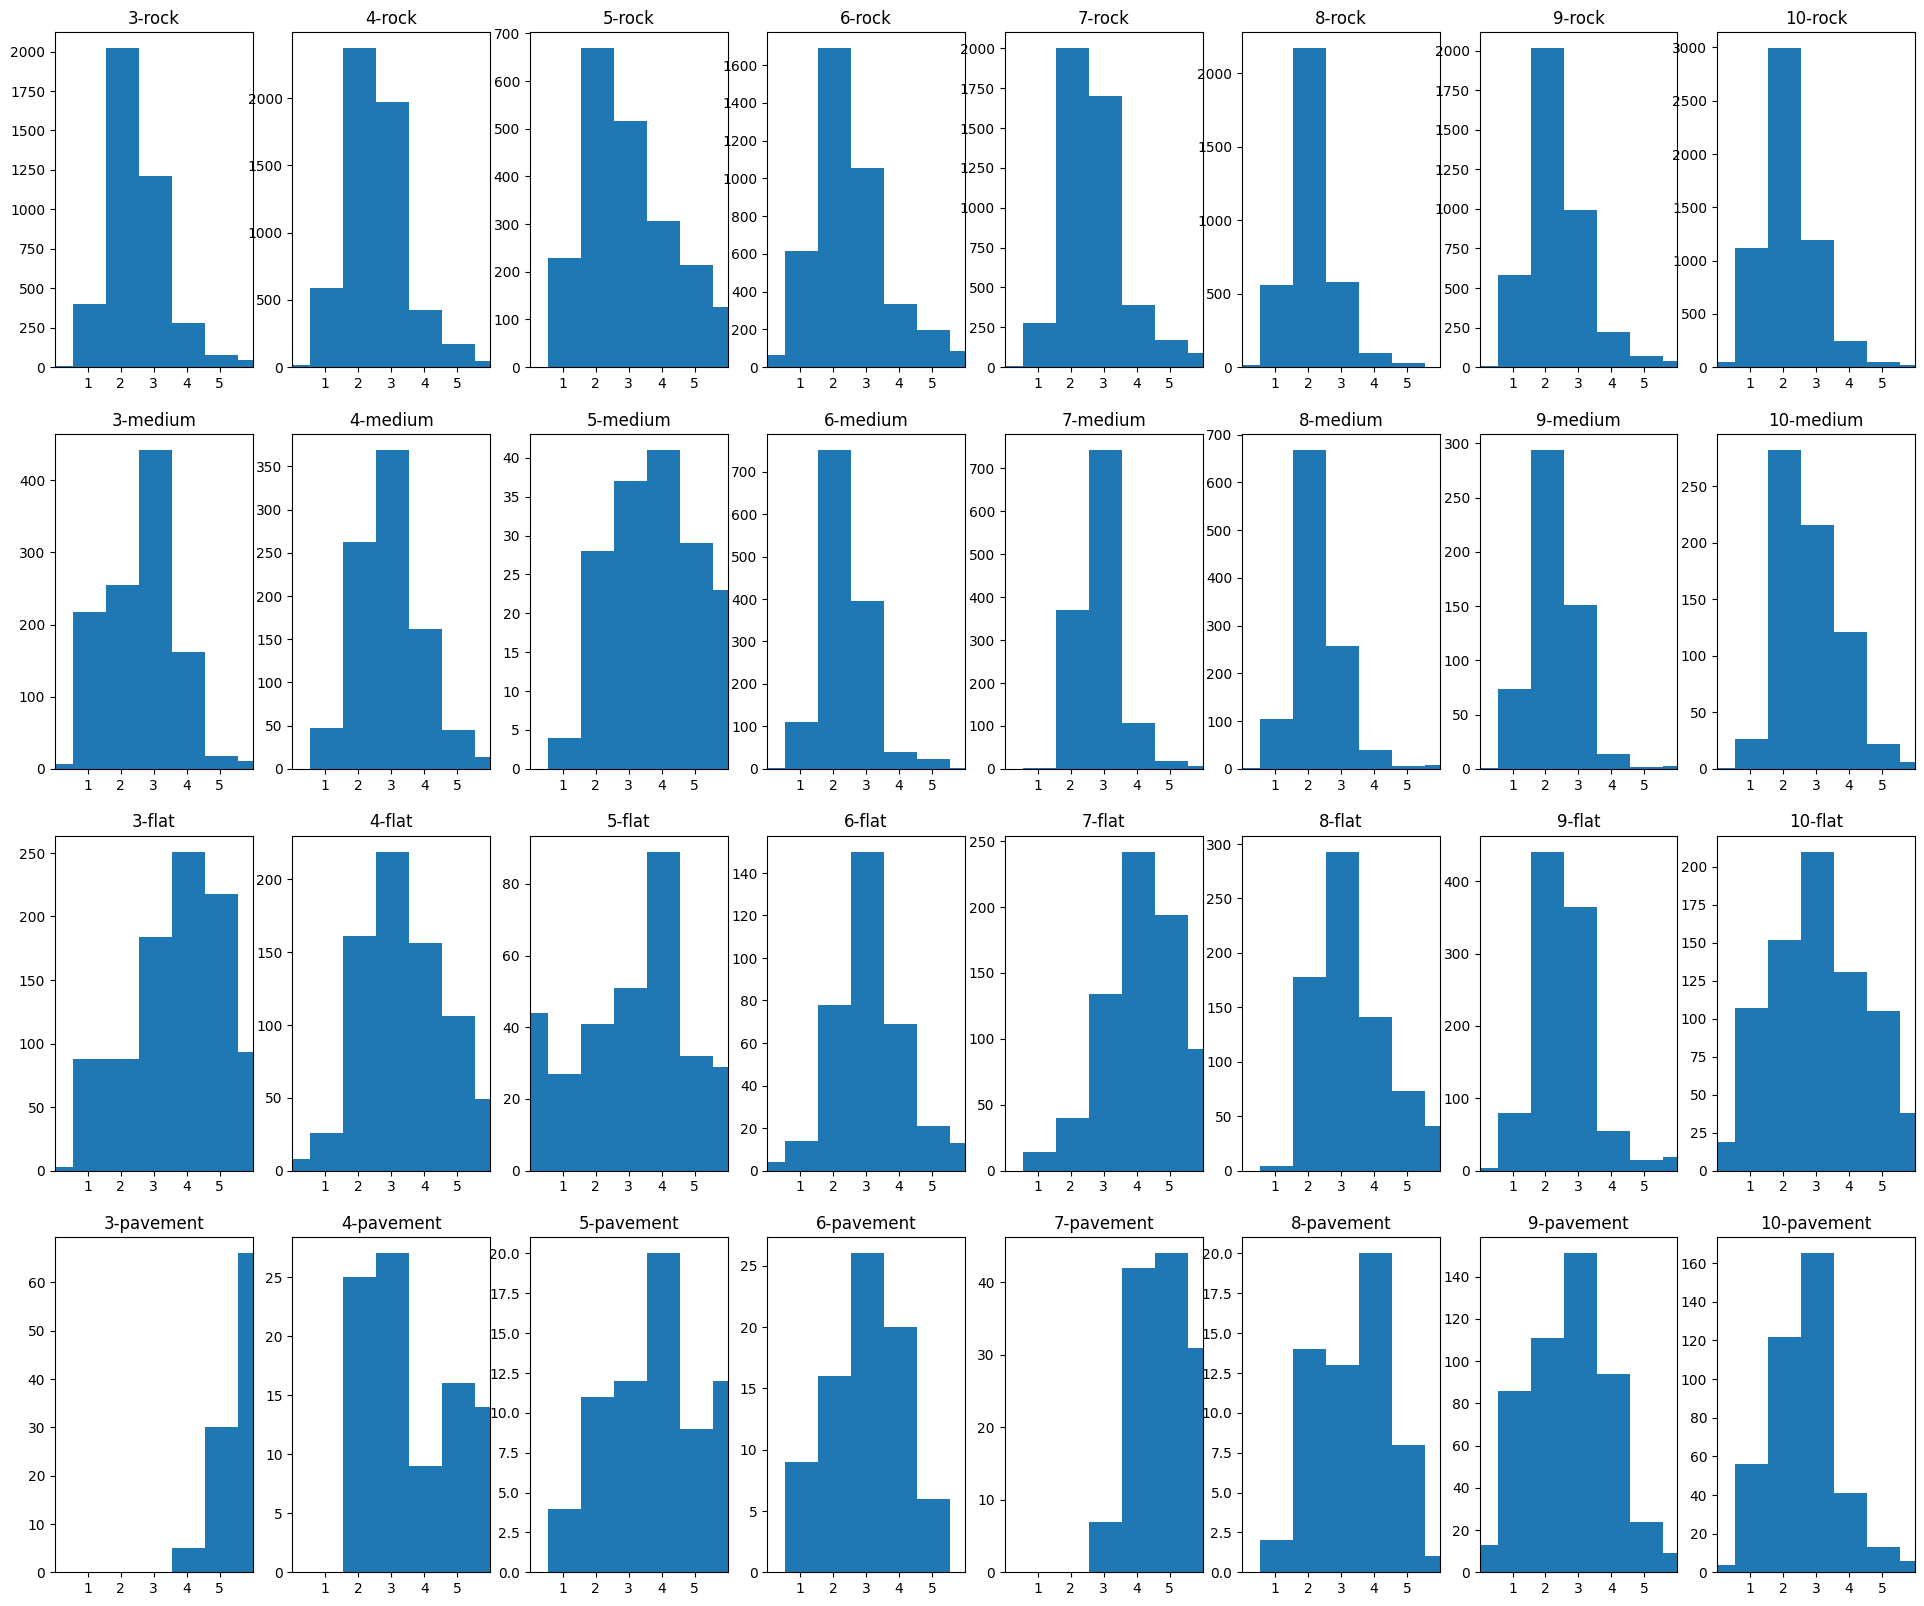

In [7]:
plt.figure(figsize=(24,20))
n=1
for terrain in terrain_types:
    for subj,si in enumerate(steps[terrain]):  
        plot_par(4,8,n,si)
        plt.title(f'{subj+3}-{terrain}')
        n+=1

plt.tight_layout

plt.show()

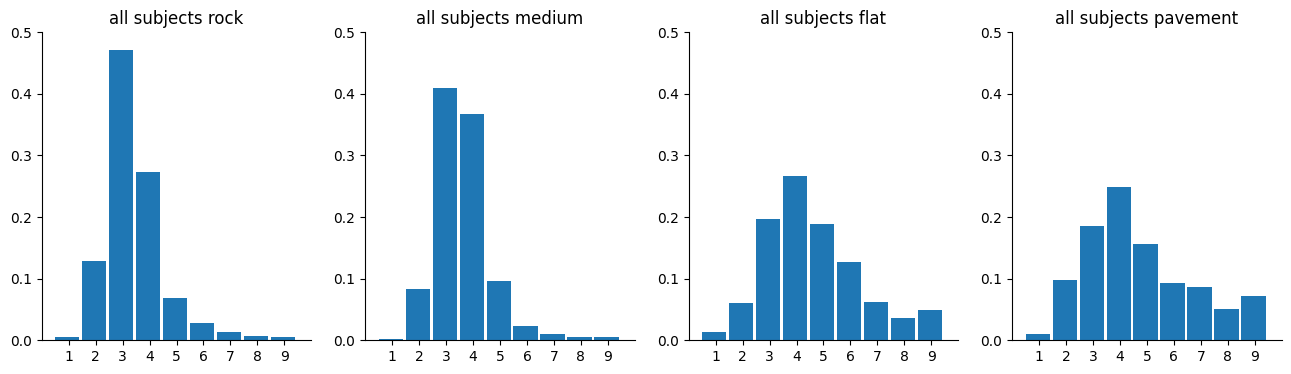

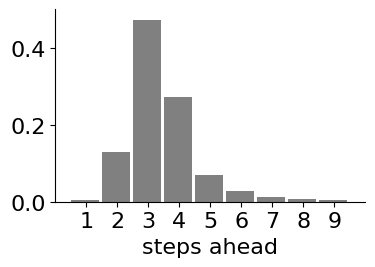

In [21]:
plt.figure(figsize=(16,4))

for n,terrain in enumerate(terrain_types):

    ax=plt.subplot(1,4,n+1)
    all_steps = np.concatenate(steps[terrain])
    plt.hist(all_steps, bins= np.arange(10), align = 'right', rwidth = 1.88,density=True,width=.9)
    plt.xlim(0,10)
    plt.ylim(0,.5)
    plt.xticks(np.arange(1,10,1))
    plt.title(f'all subjects {terrain}')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()


n=1
terrain = 'rock'
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(4,2.5))
all_steps = np.concatenate(steps[terrain])
plt.hist(all_steps, bins= np.arange(10), align = 'right', rwidth = 1.88,density=True,color=[.5,.5,.5],width=.9)
plt.xlim(0,10)
plt.ylim(0,.5)
plt.xlabel('steps ahead')
plt.xticks(np.arange(1,10,1))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('fixation-histograms-aggregate-rock.pdf')
#     plt.title(f'all subjects {terrain}')
plt.show()

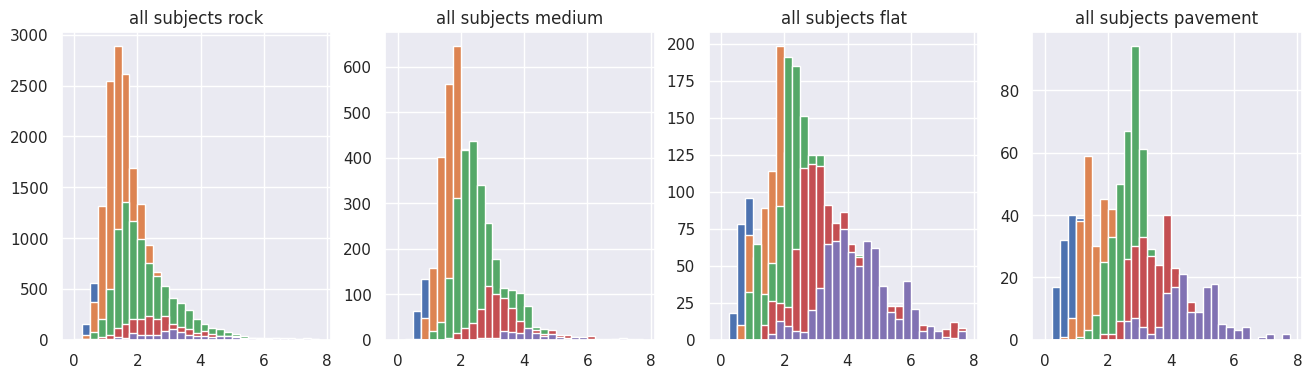

In [13]:
plt.figure(figsize=(16,4))

# NEED TO NORMALIZE BY LEG LENGTH!!!

for n,terrain in enumerate(terrain_types):

    plt.subplot(1,4,n+1)
    all_steps = np.concatenate(steps[terrain])
    all_distances = np.concatenate(distances_leg[terrain])
    for ii in range(1,6):
        plt.hist(all_distances[all_steps==ii],bins= np.arange(0,8,.25),density=False)
    
    plt.title(f'all subjects {terrain}')
plt.show()

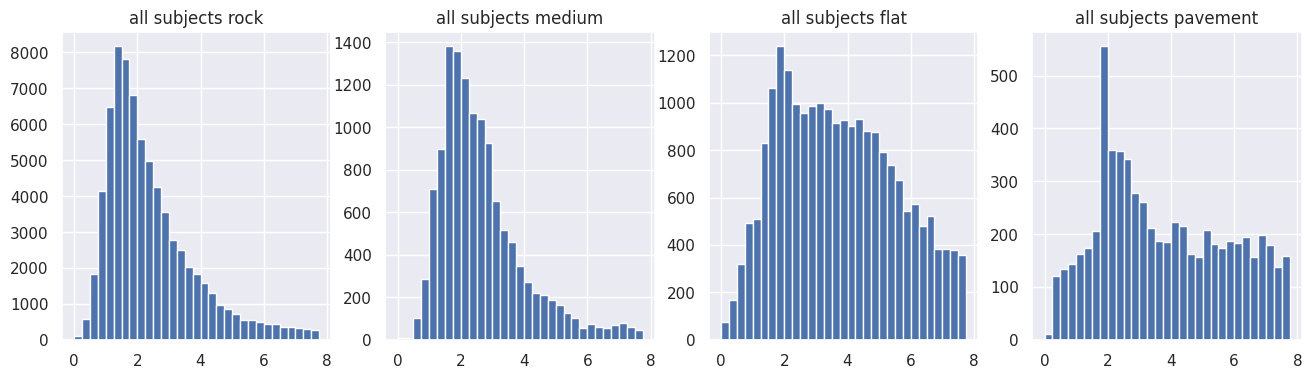

In [9]:
plt.figure(figsize=(16,4))

for n,terrain in enumerate(terrain_types):

    plt.subplot(1,4,n+1)
    all_distances = np.concatenate(distances[terrain])
    plt.hist(all_distances,bins= np.arange(0,8,.25),density=False)
    
    plt.title(f'all subjects {terrain}')
plt.show()